In [1]:
# computational libs
from scipy.spatial import Delaunay
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import cm
import time
import sparse
import random
# %matplotlib

#vtk libs
from tvtk.api import tvtk
from mayavi.scripts import mayavi2
from PyQt5 import QtCore
import sip
import vtk

#emc3 libs
import numpy as np
import xarray as xr
import netCDF4

In [2]:
# importing the mayavi plotting lib
from mayavi import mlab
# this must be run as the first line, telling jupyter that can be interactively used
%gui qt

In [3]:
from grid import grid

In [4]:
# importing widget libs to make interactive plots
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [5]:
# open the dataset containing the emc3 example
path = r"~/Dokumente/emc3_example.nc"
ds = xr.open_dataset(path)
#ds

In [6]:
%%writefile manual_tessalation.py

def manual_tessalation(grid_obj, int_R = [None, None], int_t = [None, None], int_p = [None, None]):
    """
    The problem is that it is not possible to merge two Delaunay objects or add additional points.
    Possible strategy is to do a search and find out for which of the tetrahedra of each 3d romboid 
    each point is interior to.
    """
    dict_p_tetrahedron = {}
    n = 3
    gridflat = np.zeros((n**3,) + (3,))
    
    """
    Defining the restriction on the region we do the triangulation on. 
    Iterate from a to b in all directions.
    """
    air = int_R[0]
    bir = int_R[1]
    if not bir:
        bir = grid_obj.tor_x.shape[0]-n
    if not air:
        air = 0
        
    ait = int_t[0]
    bit = int_t[1]
    if not bit:
        bit= grid_obj.tor_x.shape[1]
    if not ait:
        ait = 0
        
    aip = int_p[0]
    bip = int_p[1]
    if not bip:
        bip = grid_obj.tor_x.shape[2]-n
    if not aip:
        aip = 0
        

    for ir in range(air, bir):
        for it in range(ait, bit):
            for ip in range(aip, bip):
                if grid_obj.tor_x.shape[1]-n <= it:
                    nlow = it-grid_obj.tor_x.shape[1]
                    nhigh = nlow + n-1
                    idxs_t = np.linspace(nlow,nhigh,n, dtype = np.int32)
                    gridflat[:,0] = grid_obj.tor_x[ir:(ir + n), idxs_t, ip:(ip + n)].flatten()
                    gridflat[:,1] = grid_obj.tor_y[ir:(ir + n), idxs_t, ip:(ip + n)].flatten()
                    gridflat[:,2] = grid_obj.tor_z[ir:(ir + n), idxs_t, ip:(ip + n)].flatten()
                else:
                    gridflat[:,0] = grid_obj.tor_x[ir:(ir + n), it:(it + n), ip:(ip + n)].flatten()
                    gridflat[:,1] = grid_obj.tor_y[ir:(ir + n), it:(it + n), ip:(ip + n)].flatten()
                    gridflat[:,2] = grid_obj.tor_z[ir:(ir + n), it:(it + n), ip:(ip + n)].flatten()
                tri = Delaunay(gridflat)
                idx_tri = tri.simplices
                coord_tri = gridflat[idx_tri]

                minx = np.min(gridflat[:,0])
                maxx = np.max(gridflat[:,0])
                miny = np.min(gridflat[:,1])
                maxy = np.max(gridflat[:,1])
                minz = np.min(gridflat[:,2])
                maxz = np.max(gridflat[:,2])

                epsx = grid_obj.cart_x[1,0,0] - grid_obj.cart_x[0,0,0]
                epsy = grid_obj.cart_y[0,1,0] - grid_obj.cart_y[0,0,0]
                epsz = grid_obj.cart_z[0,0,1] - grid_obj.cart_z[0,0,0]
            
                idx_inside = np.argwhere((minx - epsx < grid_obj.cartflat[:,0]) & (maxx + epsx > grid_obj.cartflat[:,0]) &
                                         (miny - epsy < grid_obj.cartflat[:,1]) & (maxy + epsy > grid_obj.cartflat[:,1]) &
                                         (minz - epsz < grid_obj.cartflat[:,2]) & (maxz + epsz > grid_obj.cartflat[:,2]) )
                for i in idx_inside:
                    p = grid_obj.cartflat[i][0]
                    idx_simplex_embed_p = tri.find_simplex(p)
                    if idx_simplex_embed_p != -1:
                        p_tuple = tuple(list(p))
                        dict_p_tetrahedron[p_tuple] = coord_tri[idx_simplex_embed_p]                

    return dict_p_tetrahedron

Overwriting manual_tessalation.py


In [7]:
%%writefile interpolation_p_in_simplex.py

"""
Now that we have found all coordinates and 
the tetrahedra of which they are interior, we want to assign values to each point
interior to each tetrahedra by using an interpolation scheme.

Interpolation scheme 1:

Weighted values by normalized inverse distance to each vertex of the tetrahedron.
By normalized we mean the sum of the inverse distances should equal 1.
"""

def interpolation_p_in_simplex(p, simplex, dict_vals):
    """
    Args:
    p - ndarray np.float64, (x,y,z) cart coords of p in tetrahedron/simplex, dim (3,)
    simplex - ndarray np.float64, (x,y,z) cart coord of each vertex of tetrahedron/simplex, dim (4,3)
    dict_vals - dictionary value scalar valuesof potential, key coord of a vertex, 
                len = number of grid points in toroidal coord
    Out:
    paramval = ndarray np.float64, scalar, 
               param value interpolated from param vals at vertices, dim (1,)
    """
    vals = []
    for i in range(len(simplex)):
        vals.append(dict_vals[tuple(simplex[i])])
    vals = np.asarray(vals, np.float64)
    euc_dists = np.sqrt(np.sum((simplex - p)**2, axis = 1)) + 1e-8
    N = 1/(np.sum(1/euc_dists, axis=0))
    paramval = np.sum(N*vals/euc_dists, axis = 0)
    return paramval

Overwriting interpolation_p_in_simplex.py


In [8]:
%%writefile make_param_mesh_tess.py
"""
Now test the interpolation method wiht actual potential data from the exponentially decaying potential.
"""
def make_param_mesh(dict_p_tetra, grid_obj, param_torgrid, ret_dict = False, ret_nans = False):
    """
    Args:
     - dict_p_tetra, dict with key coordinate of point and values tetrahedron which the point is interior to
     - grid_obj, grid object containing the different grid structures
     - param_torgrid, parameter
     - ret_dict, bool return dict with key coordinate and value parameter value
     - ret_nans, bool return dict of nan values
    Out:
     - parammesh, ndarray np.float64, meshgrid of parameter values
     - if ret_dict and ret_nans is True, return them as well
    
    Make a dictionary with key = coord xyz and value = potential value 
    of the potential values connected to grid points from the toroidal grid.

    """
    dict_coord_tpot = {}
    dict_coord_nan = {}
    for i in range(len(grid_obj.torflat)):
        dict_coord_tpot[tuple(grid_obj.torflat[i])] = param_torgrid.flatten()[i]

    # Points interior to one of the tetrahedra that the toroidal volume is divided in
    ps_interior = np.asarray(list(dict_p_tetra.keys()), dtype = np.float64)

    # Make a dictionary with key coord, value interpolated parameter value
    dict_coord_pot_interpol = {}
    
    # Make a meshgrid of interpolated parameter values
    parammesh = np.nan*np.ones(grid_obj.cart_x.shape)
    
    for i in range(len(ps_interior)):
        coord_idx = np.argwhere((grid_obj.cart_x == ps_interior[i][0]) & 
                                (grid_obj.cart_y == ps_interior[i][1]) & 
                                (grid_obj.cart_z == ps_interior[i][2]))[0] 
        parammesh[coord_idx[0], coord_idx[1], coord_idx[2]] = interpolation_p_in_simplex(p = ps_interior[i],
                                                                                         simplex = dict_p_tetra[tuple(ps_interior[i])],
                                                                                         dict_vals = dict_coord_tpot)
        if parammesh[coord_idx[0], coord_idx[1], coord_idx[2]] == np.nan:
            dict_coord_nan[ps_interior[i]] = np.nan
        if ret_dict:
            dict_coord_pot_interpol[tuple(ps_interior[i])] = parammesh[coord_idx[0], coord_idx[1], coord_idx[2]]
    if ret_nans:
        ret = [parammesh, dict_coord_nan]
    if ret_dict:
        ret = [parammesh, dict_coord_pot_inerpol]
    ret = parammesh
    return ret

Overwriting make_param_mesh_tess.py


In [9]:
%%writefile grid.py

class grid:
    def __init__(self, ds, ngrid_cart = None, inc_r = [None, None], inc_t = [None, None], inc_p = [None, None]):
        """
        Args:
         - xarray, ds is a dataset containing the W7X data
         - np.int64, ngrid_cart is cartesian grid resolution 
         - list dim 2 (min,max), inc_r, inc_t, inc_p is the minmax of the grid indexes in r, theta and phi direction
         
        Out:
         - grid object, both cartesian meshgrid of toroidal and cartesian grid, can also get as flattened arrays
        
        Note: Periodic boundary conditions is added in theta direction
        """
        import numpy as np
        
        dgrid = np.asarray( ds.R_bounds.mean(dim=("delta_r", "delta_theta", "delta_phi")) )[inc_r[0]:inc_r[1],
                                                                                            inc_t[0]:inc_t[1],
                                                                                            inc_p[0]:inc_p[1]].shape
        
        self.R, self.theta, self.phi, self.tor_z = np.ones(dgrid)*np.nan, np.ones(dgrid)*np.nan, np.ones(dgrid)*np.nan, np.ones(dgrid)*np.nan
        
        self.R = np.asarray( ds.R_bounds.mean(dim=("delta_r", "delta_theta", "delta_phi")) )[inc_r[0]:inc_r[1],
                                                                                             inc_t[0]:inc_t[1],
                                                                                             inc_p[0]:inc_p[1]]

        
        self.tor_z = np.asarray(ds.z_bounds.mean(dim=("delta_r", "delta_theta", "delta_phi")))[inc_r[0]:inc_r[1],
                                                                                               inc_t[0]:inc_t[1],
                                                                                               inc_p[0]:inc_p[1]]

        
        self.phi = np.asarray( ds.phi_bounds.mean(dim="delta_phi") )[inc_p[0]:inc_p[1]]

        
        self.tor_x = np.asarray( self.R * np.cos(self.phi) )
        self.tor_y = np.asarray( self.R * np.sin(self.phi) )
        if ngrid_cart == None:
            ngrid_cart = 100
        
        ivl_p = int(inc_p[1] - inc_p[0])
        #chunking = 4
        #chunkingids = 0,0,0
        """self.cart_x, self.cart_y, self.cart_z = np.meshgrid(np.linspace(np.min(self.tor_x),np.max(self.tor_x)[ngrid_cart // chunking*chunkingids[0]:ngrid_cart // chunking*(chunkingids[0]+1)], ngrid_cart), 
                                                            np.linspace(np.min(self.tor_y),np.max(self.tor_y), ngrid_cart), 
                                                            np.linspace(np.min(self.tor_z),np.max(self.tor_z), ngrid_cart),
                                                            indexing = "ij")"""
        self.cart_x, self.cart_y, self.cart_z = np.meshgrid(np.linspace(np.min(self.tor_x),np.max(self.tor_x), ngrid_cart), 
                                                            np.linspace(np.min(self.tor_y),np.max(self.tor_y), ngrid_cart), 
                                                            np.linspace(np.min(self.tor_z),np.max(self.tor_z), ngrid_cart),
                                                            indexing = "ij")
     
        self.cartflat = np.ones((self.cart_x.shape[0]*self.cart_x.shape[1]*self.cart_x.shape[2], 3) )*np.nan
        self.cartflat[:,0] = self.cart_x.flatten()
        self.cartflat[:,1] = self.cart_y.flatten()
        self.cartflat[:,2] = self.cart_z.flatten()
        
        self.torflat = np.ones((self.tor_x.shape[0]*self.tor_x.shape[1]*self.tor_x.shape[2], 3))*np.nan
        self.torflat[:,0] = self.tor_x.flatten()
        self.torflat[:,1] = self.tor_y.flatten()
        self.torflat[:,2] = self.tor_z.flatten()

Overwriting grid.py


In [10]:
def make_parammesh_vtk(grid_obj, sgrid, param_torgrid, ret_nans = False):
    """
    Args:np sparsenp sparse
     - grid_obj, grid object defined in one of the cells below
     - sgrid, tvtk.StructureGrid object
     - param_torgrid, type ndarray, parameter of interest on a toroidal meshgrid structure
     - renans, bool, return NaN vales of points found in a cell or not
    Out:
     - parammesh, ndarray, interpolated parameter values on a 3d cartesian grid
    """
    import numpy as np
    import vtk
    from tvtk.api import tvtk
    import itertools
    # make a dict to store potential nan values that appear in points found in a cell
    dictnans = {}
    notfound = []
    
    # make the mehsgrid for the parameter we want to interpolate form the original data
    parammesh = np.nan*np.ones(grid_obj.cart_x.shape)
    
    # pass initial/default values to the find_cell function
    cell = None
    cid = int(6e3)
    tol2 = 1e-3
    subid = vtk.reference(-1)
    pcoord = np.zeros((3))
    weights = np.zeros(8)
    
     #making coarse grid
    numc = 20
    coarse = np.zeros((numc, numc, numc), dtype=bool)
    spatial_toroidal = np.array([grid_obj.__dict__["tor_"+d] for d in "xyz"])
    minmax = [np.array([func(grid_obj.__dict__["tor_"+d]) for d in "xyz"]) for func in [np.min, np.max]]
    offset = minmax[0]
    dist = (minmax[1] - minmax[0]+1e-6)/numc
    for i,j,k in itertools.product(*[range(x-1) for x in grid_obj.tor_x.shape]):
        block = spatial_toroidal[:,i:i+2, j:j+2, k:k+2].reshape(3, 8)
        minmax = [func(block, axis=1) for func in [np.min, np.max]]
        indices = [((m - offset) / dist).astype(int) for m in minmax]
        for ijk in itertools.product(*[range(a,b+1) for a,b in zip(*indices)]):
            coarse[ijk] = True
    
    # iterate through points in the cartesian grid
    for pid, p in enumerate(grid_obj.cartflat):
        # check the coarse grid for points first
        if not coarse[tuple(((p-offset)/dist).astype(int) )]:
            continue
        #find the cell p is interior to
        cid = sgrid.find_cell(p, cell, cid, tol2, subid, pcoord, weights)
        # if find_cell returns -1 there is either a numerical error or it did not find the point in that cell
        if cid == -1:
            notfound.append(cid)
            continue
        else:            
            # unravel index of each vertex of the cell found from the toroidal grid
            newgridshape = (grid_obj.tor_x.shape[0]-1, grid_obj.tor_x.shape[1]-1, grid_obj.tor_x.shape[2]-1)

            # get indicies of the cell corner
            ir, it, ip = np.unravel_index(cid, newgridshape)

            #find the potential values of each vertex of the cell and interpolate the data using weights
            pvals = param_torgrid[ir:(ir+2), it:(it+2), ip:(ip+2)].ravel() * weights
            paramval = np.sum(pvals, axis = 0)

            # find coordinate indices of the point in the cartesian grid structure with cartesian indicies
            coord_idx = np.argwhere((grid_obj.cart_x == p[0]) & 
                                    (grid_obj.cart_y == p[1]) & 
                                    (grid_obj.cart_z == p[2]))[0] 
            # Assign the cartesian parameter mesh the parameter value
            parammesh[coord_idx[0], coord_idx[1], coord_idx[2]] = paramval
            
    # if user input chosen return nans then return nans 
    if ret_nans:
        # generate different return when including the dictionary containing the nans
        return parammesh, dictnans, notfound
    else:
        return parammesh, notfound

In [11]:
# %%writefile makemesh_indices.py
# def make_parammesh_vtk_indices(grid_obj, sgrid, skip_coarsegrid = 10):
#     """
#     Args:
#      - grid_obj, grid object defined in one of the cells below
#      - sgrid, tvtk.StructureGrid object
#      - renans, bool, return NaN vales of points found in a cell or not
#     Out:
#      - parammesh_indices, ndarray np.int32, interpolated parameter vertex indices and weights on a 3d cartesian grid
#      dim = (x, y, z, coord index vertices of cell/weights of vertices)
#     """
#     import numpy as np
#     import vtk
#     from tvtk.api import tvtk
#     import itertools
#     # need to have grid.py in the same folder as this py file
#     from grid import grid
    
#     # make the mehsgrid for the parameter we want to interpolate form the original data
#     # + (2,8) represents (indices/weights, vertex)
#     parammesh_indices = np.nan*np.ones(grid_obj.cart_x.shape + (2,8), dtype=np.int32)
    
#     # pass initial/default values to the find_cell function
#     cell = None
#     cid = int(6e3)
#     tol2 = 1e-3
#     subid = vtk.reference(-1)
#     pcoord = np.zeros((3))
#     weights = np.zeros(8)
#     # iterate through points in the cartesian grid
    
#     #making coarse grid to speed up the find point in cell stage
#     numc = 20
#     coarse = np.zeros((numc, numc, numc), dtype=bool)
#     #spatial_toroidal = np.array([grid_obj.__dict__[d] for d in ("R", "tor_z", "phi")])
#     #minmax = [np.array([func(grid_obj.__dict__[d]) for d in ("R", "tor_z", "phi")]) for func in [np.min, np.max]]
#     spatial_toroidal = np.array([grid_obj.__dict__["tor_"+d] for d in "xyz"])
#     minmax = [np.array([func(grid_obj.__dict__["tor_"+d]) for d in "xyz"]) for func in [np.min, np.max]]
#     offset = minmax[0]
#     dist = (minmax[1] - minmax[0]+1e-6)/numc
#     for i,j,k in itertools.product(*[range(x-1) for x in grid_obj.tor_x.shape]):
#         block = spatial_toroidal[:,i:i+2, j:j+2, k:k+2].reshape(3, 8)
#         minmax = [func(block, axis=1) for func in [np.min, np.max]]
#         indices = [((m - offset) / dist).astype(int) for m in minmax]
#         for ijk in itertools.product(*[range(a,b+1) for a,b in zip(*indices)]):
#             coarse[ijk] = True
    
#     # generate the shape of the cellular emc3 grid
#     grid_of_cells_shape = (grid_obj.tor_x.shape[0]-1, grid_obj.tor_x.shape[1]-1, grid_obj.tor_x.shape[2]-1)
#     for p in grid_obj.cartflat:
# #         if sg_cg.find_cell(p, None, -1, 1e-3, vtk.reference(-1), np.zeros(3), np.zeros(8)) == -1:
# #             continue
# #         rzp = np.sqrt(np.sum(p[:2]**2)), p[2], np.arctan2(p[1], p[0])
# #         if not coarse[tuple(((p-offset)/dist).astype(int) )]:
# #             continue
#         #find the cell p is interior to
#         cid = sgrid.find_cell(p, cell, cid, tol2, subid, pcoord, weights)
#         # if find_cell returns -1 there is either a numerical error or it did not find the point in that cell
#         if cid == -1:
#             continue
#         else:            
#             # unravel index of each vertex of the cell found from the toroidal grid
#             ir, it, ip = np.unravel_index(cid, grid_of_cells_shape)
#             idx = np.zeros((2,2,2), dtype=int)
#             for d_ir, dit, dip in itertools.product(range(2), repeat=3):
#                 idx[d_ir, dit, dip] = np.ravel_multi_index((ir+d_ir,it+dit,ip+dip), grid_obj.tor_x.shape)
#             idx.shape = 8
#             # find coordinate indices of the point in the cartesian grid structure with cartesian indices
#             coord_idx = np.argwhere((grid_obj.cart_x == p[0]) & 
#                                     (grid_obj.cart_y == p[1]) & 
#                                     (grid_obj.cart_z == p[2]))[0]
#             #represents the indices of the flattened parametermesh on the emc3 grid structure
#             parammesh_indices[coord_idx[0], coord_idx[1], coord_idx[2],0] = idx
#             # represents the weights corresponding to the parameter indices above
#             parammesh_indices[coord_idx[0], coord_idx[1], coord_idx[2],1] = weights
#     return parammesh_indices

# def from_indices_to_paramvals(indices, param_torgrid):
#     """
#     Current problem is that it is not identical to the former method where the the parametervalues are extracted
#     rather than the indices of the toroidal grid.
#     """
#     #imports for importing to external file later
#     import numpy as np
    
#     # shape pmesh as (50,50,50), if ngrid = 50
#     pmesh = np.ones(indices.shape[:3])*np.nan
#     # shape = (50, 50, 50, 8)
#     weights = indices[:,:,:,1]
#     # goal to convert idxs to parametervalues
#     idxs = indices[:,:,:,0]
#     # make a flattened array of sum of indices of all vertices in the cell, if any is nan then discard the cell
#     irav = np.sum(idxs, axis = 3).ravel()
#     # store indices of indices which are numbers in a flattened structure
#     isnotnan = np.where(np.isnan(irav) == False)[0]
#     # array of indexes that is not nanvalued
#     notnanidxs = np.asarray(idxs.reshape(idxs.shape[0]**3,8)[isnotnan], dtype=np.int32)
    
#     pmesh_re = pmesh.ravel()
#     pmesh_re[isnotnan] = np.sum(param_torgrid.ravel()[notnanidxs] * weights.reshape(weights.shape[0]**3, 8)[isnotnan], axis = 1)
#     pmesh = pmesh_re.reshape(indices.shape[:3])
#     return pmesh   

In [12]:
# %%writefile makemesh_indices.py
def make_parammesh_vtk_indices(grid_obj, sgrid, skip_coarsegrid = 10, sp = (29,2,16)):
    """
    Args:
     - grid_obj, grid object defined in one of the cells below
     - sgrid, tvtk.StructureGrid object
     - renans, bool, return NaN vales of points found in a cell or not
    Out:
     - parammesh_indices, ndarray np.int32, interpolated parameter vertex indices and weights on a 3d cartesian grid
     dim = (x, y, z, coord index vertices of cell/weights of vertices)
    """
    import numpy as np
    import vtk
    from tvtk.api import tvtk
    import itertools
    # need to have grid.py in the same folder as this py file
    from grid import grid
    
    # make the mehsgrid for the parameter we want to interpolate form the original data
    # + (2,8) represents (indices/weights, vertex)
    parammesh_indices = -np.ones(grid_obj.cart_x.shape + (8,), dtype=np.int32 )
    parammesh_weights = np.nan*np.ones(grid_obj.cart_x.shape + (8,), dtype=np.float32)
    # pass initial/default values to the find_cell function
    cell = None
    cid = int(6e3)
    tol2 = 1e-3
    subid = vtk.reference(-1)
    pcoord = np.zeros(3)
    weights = np.zeros(8, dtype=np.float32)
    
    # generate the shape of the cellular emc3 grid
    grid_of_cells_shape = (grid_obj.tor_x.shape[0]-1, grid_obj.tor_x.shape[1]-1, grid_obj.tor_x.shape[2]-1)
    
    # for storing cell ids of the emc3 grid to each grid point in the cartesian grid
    cids = np.zeros(grid_obj.cart_x.shape, dtype=np.int32)-2
    cs = sp # this is now hardcoded, need to find a generalized solution
    todo = [tuple(list(cs))] #starting index of point to search for in the cells to search
    found = False
    while todo:
        cur = todo.pop()
        #find the cell p is interior to
        cid = sgrid.find_cell([grid_obj.cart_x[cur], grid_obj.cart_y[cur], grid_obj.cart_z[cur]], 
                              cell, cid, tol2, subid, pcoord, weights)
        cids[cur] = cid
        if cid >= 0:
            found = True
            for dist in itertools.product(range(-1,2),repeat=3): #iterate through neighbours
                nxt = tuple(a+b for a,b in zip(dist, cur))
                if nxt > grid_obj.cart_x.shape or nxt[1:]>grid_obj.cart_x.shape[1:] or nxt[2:]>grid_obj.cart_x.shape[2:]: #is out of bounds:
                    continue
                if cids[nxt] == -2:
                    cids[nxt] = -3
                    todo.append(nxt)
            # unravel index of each vertex of the cell found from the toroidal grid
            ir, it, ip = np.unravel_index(cid, grid_of_cells_shape)
            idx = np.zeros((2,2,2), dtype=int)
            for d_ir, dit, dip in itertools.product(range(2), repeat=3):
                idx[d_ir, dit, dip] = np.ravel_multi_index((ir+d_ir,it+dit,ip+dip), grid_obj.tor_x.shape)
            idx.shape = 8
            #represents the indices of the flattened parametermesh on the emc3 grid structure
#             print(parammesh_indices.shape, parammesh_indices.dtype, cur, type(cur), idx, idx.dtype, weights, weights.dtype)
            parammesh_indices[cur] = idx
            # represents the weights corresponding to the parameter indices above
            parammesh_weights[cur] = weights
        #if find_cell returns -1 there is either a numerical error or it did not find the point in that cell
        if not found:
            print("guessing startpoint")
            cs = tuple(np.random.randint(low = 0, high = grid_obj.cart_x.shape[0]-1, size = 3))
            todo.append(cs)
    return parammesh_indices, parammesh_weights

def from_indices_to_paramvals(idxs, weights, param_torgrid):
    """
    Current problem is that it is not identical to the former method where the the parametervalues are extracted
    rather than the indices of the toroidal grid.
    """
    #imports for importing to external file later
    import numpy as np
    # shape pmesh as (50,50,50), if ngrid = 50
    pmesh = np.ones(idxs.shape[:3], dtype=np.float64)*np.nan
    # make a flattened array of sum of indices of all vertices in the cell, if any is nan then discard the cell
    irav = np.sum(idxs, axis = 3).ravel()
    # store indices of indices which are numbers in a flattened structure
    isnotnan = np.where(np.isnan(irav) == False)[0]
    # array of indexes that is not nanvalued
    notnanidxs = np.asarray(idxs.reshape(idxs.shape[0]**3,8)[isnotnan], dtype=np.int32)
    pmesh_re = pmesh.ravel()
    pmesh_re[isnotnan] = np.sum(param_torgrid.ravel()[notnanidxs] * weights.reshape(weights.shape[0]**3, 8)[isnotnan], axis = 1)
    pmesh = pmesh_re.reshape(idxs.shape[:3])
    return pmesh   

In [60]:
grid_emc3 = grid(ds = ds, ngrid_cart = 128, inc_r = [40, 138], inc_t = [0,512], inc_p = [0,10])
# cs = np.array(list(grid_emc3.cart_x.shape)) - np.array(list(grid_emc3.cart_x.shape))/np.array([20,1.2,2])
# cs = tuple(cs.astype(int))
# print(cs)

In [64]:
dimgrid = list([x for x in grid_emc3.tor_x.shape[::-1]])
sgrid_emc3 = tvtk.StructuredGrid(dimensions=dimgrid)
sgrid_emc3.points = grid_emc3.torflat
# sgrid_emc3.point_data.scalars = np.asarray(ds.Te)[40:60,:50,:4].flatten()
# sgrid_emc3.point_data.scalars.name = "Te"

In [65]:
# from makemesh_indices import make_np sparseparammesh_vtk_indices, from_indices_to_paramvals
tik = time.time()
idxmesh, weightmesh = make_parammesh_vtk_indices(grid_obj = grid_emc3,
                                                 sgrid = sgrid_emc3, sp = (0, 0, 0))
tok = time.time()
runtime_idxmesh = tok-tik

guessing startpoint
guessing startpoint
guessing startpoint
guessing startpoint


In [66]:
print("To make indicies it took ", runtime_idxmesh)
tik = time.time()
pmeshtest = from_indices_to_paramvals(idxs = idxmesh, 
                                      weights = weightmesh, 
                                      param_torgrid = np.asarray(ds.Te)[40:138,:512,:10])
tok = time.time()
print("To evaluate indicies it took ", tok - tik)

To make indicies it took  17.9334819316864
To evaluate indicies it took  0.29051756858825684


In [67]:
print(pmeshtest[64:69,4,78:84])
pmeshtest[65,4,80]

[[nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]]


nan

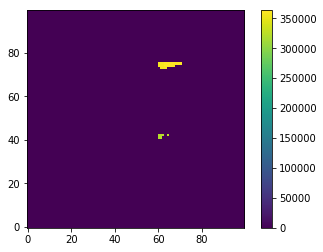

In [69]:
cell = None
cid = int(6e3)
tol2 = 1e-3
subid = vtk.reference(-1)
pcoord = np.zeros(3)
weights = np.zeros(8, dtype=np.float32)
out = np.zeros((100,100), dtype=int)
for i in range(100):
    for j in range(100):
        out[j, i] = sgrid_emc3.find_cell([grid_emc3.cart_x[65,4,80], 
                                  grid_emc3.cart_y[65,4,80]-(i-50)/1280/2, 
                                  grid_emc3.cart_z[65,4,80]-(j-50)/1280/2],
                                 cell, cid, tol2, subid, pcoord, weights)
    #print(i, found)
#plt.figure(figsize=(20,20))
plt.imshow(out, origin='lower')
plt.colorbar()
#plt.figure(figsize=(20,20))
#%matplotlib qt
#print(out[:,18])
#print(out[1:,18]- out[:-1,18])
#plt.plot(out[:,18])
#-312571 + 307972, -307972   +    0   +    0 + 303373

In [54]:
from matplotlib import pyplot as plt
hexahedron_emc3 = sgrid_emc3.get_cell(307972)
points3d = hexahedron_emc3.points.to_array()
points3d.shape
inv = points3d[::-1]
mlab.clf()
mlab.points3d(points3d[:,0], points3d[:,1], points3d[:,2], scale_factor=1e-3)
mlab.axes()
mlab.outline()

In [55]:
unrav = np.unravel_index(307972, grid_emc3.tor_x.shape)
unrav

(60, 77, 2)

(60, 77, 2)

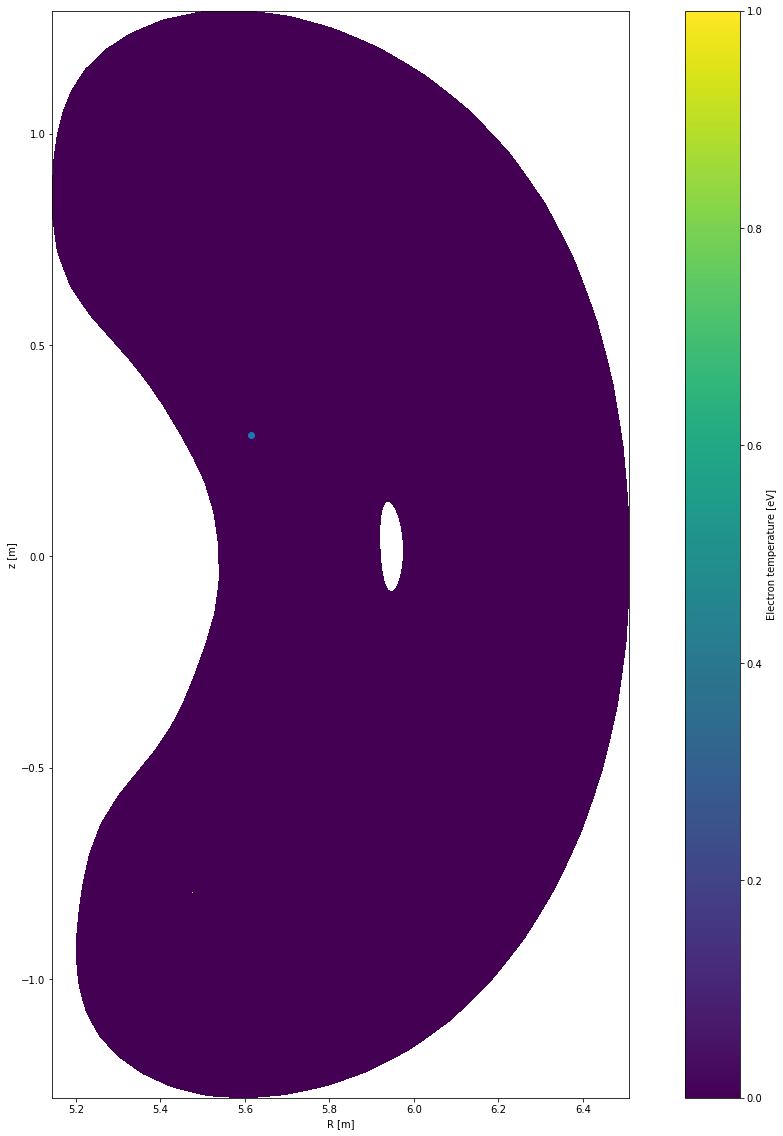

In [57]:
import xemc3
idx=65,4,80
xyz = [grid_emc3.__dict__["cart_"+d][idx] for d in "xyz"]
x,y,z =xyz
r = np.sqrt(x**2+y**2)
phi = np.arctan2(y,x)
ds["tmp"] = ds.Te.copy()
ds.tmp.data[...] = 0

plt.figure(figsize=(20,20))
ds.tmp.data[60,77] = 1
ds.emc3.plot_Rz("tmp", phi)
plt.scatter(r, z)
#ds.tmp.data.shape
unrav

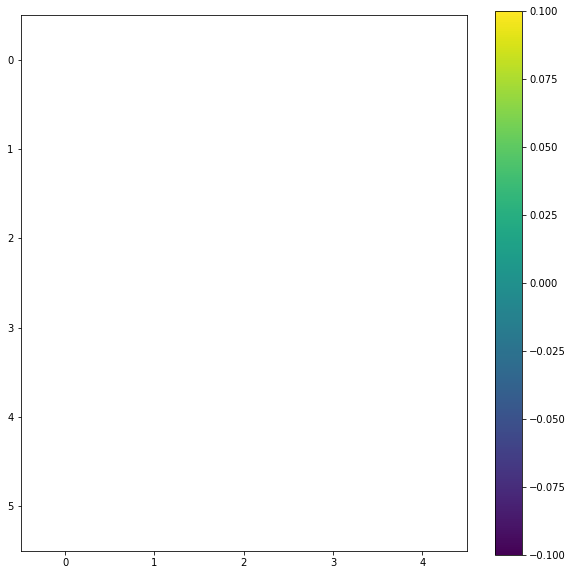

<function __main__.plot_Te(iy)>

In [58]:
def plot_Te(iy):
    plt.figure(figsize=(10,10))
    im = plt.imshow(pmeshtest[64:69,:,78fig = plt.figure()
ax = fig.add_subplot(projection='3d')fig = plt.figure()
ax = fig.add_subplot(projection='3d'):84].T[::-1][:,iy])
    plt.colorbar(im)
iy = widgets.IntSlider(min = 0, max = pmeshtest.shape[1]-1, value = 4)
interact(plot_Te, iy = iy)

In [ ]:
"""
Plotting the actual values in the W7X grid.
"""

# View the data.
@mayavi2.standalone
def view():
    from mayavi.sources.vtk_data_source import VTKDataSource
    from mayavi.modules.api import Outline, GridPlane

    mayavi.new_scene()
    src = VTKDataSource(data=sgrid_emc3)
    mayavi.add_source(src)
    mayavi.add_module(Outline())
    g = GridPlane()
    g.grid_plane.axis = 'x'
    mayavi.add_module(g)
    g = GridPlane()
    g.grid_plane.axis = 'y'
    mayavi.add_module(g)
    g = GridPlane()
    g.grid_plane.axis = 'z'
    mayavi.add_module(g)

if __name__ == '__main__':
    view()

In [ ]:
"""
Do the actual interpolation. Measures the runtime with tik tok.
"""
from make_parammesh_vtk import make_parammesh_vtk
tik = time.time()
Te_mesh_vtk, notfound_emc3 = make_parammesh_vtk(grid_obj = grid_emc3,
                                                sgrid = sgrid_emc3,
                                                param_torgrid = np.asarray(ds.Te)[20:60,:50,:4], 
                                                ret_nans = False )
tok = time.time()

In [ ]:
print("The vtk interpolation took ", tok - tik, "seconds to run for an increment of phi by 3.")
# print("Len dictnans", len(dictnans_emc3))
print("Len notfound", len(notfound_emc3))

In [ ]:
"""
Confirm equal shapes!
"""
# Te_mesh_vtk.shape
# Te_mesh_vtk.flatten().shape
# grid_emc3.cartflat.shape

In [ ]:
# np.where(np.isnan(Te_mesh_vtk) == False)[0].shape

In [ ]:
"""
Y-slices of interpolated data.
"""
# %matplotlib
def plot_Te(iy):
    plt.figure(figsize=(10,10))
    im = plt.imshow(Te_mesh_vtk.T[::-1][:,iy])
    plt.colorbar(im)
iy = widgets.IntSlider(min = 0, max = Te_mesh_vtk.shape[1]-1, value = 2)
interact(plot_Te, iy = iy)

In [ ]:
# visualize contour of the interpolated values in 3d with colors defined by electron temperature
dimgrid_cart = list(grid_emc3.cart_x.shape)
sgrid_cart_emc3 = tvtk.StructuredGrid(dimensions=dimgrid_cart)
s_Te = pmeshtest.copy()
sgrid_cart_emc3.points = grid_emc3.cartflat
sgrid_cart_emc3.point_data.scalars = s_Te.ravel()
sgrid_cart_emc3.point_data.scalars.name = "Te"

mlab.clf()
#add the dataset to the pipeline
src_cart = mlab.pipeline.add_dataset(sgrid_cart_emc3)
cut_cart = mlab.pipeline.scalar_cut_plane(src_cart)
cont_cart = mlab.pipeline.iso_surface(src_cart)

In [ ]:
"""
Comparing the interpolated region with what I should see.
"""
def plot_emc3toroidal(ip):
    figemc3 = plt.figure(figsize=(15,15))
    axemc3 = figemc3.add_subplot()
    clev = np.arange(ds.Te[20:80,:,ip].min(),ds.Te[20:80,:,ip].max(),.5)
    cemc3 = axemc3.contourf(grid_emc3.R[:,:,ip], 
                            grid_emc3.tor_z[:,:,ip], 
                            ds.Te[20:80,0:50,ip], 
                            clev)
    figemc3.colorbar(cemc3)
phislider = widgets.IntSlider(min = 0, max = 3, value = 0)
interact(plot_emc3toroidal, ip = phislider)

In [ ]:
"""
do the same using unstructured grid just to get 
to know how to work with different grid structures
"""

tet_type = tvtk.Tetra().cell_type # VTK_TETRA == 10
tets = np.arange(len(grid_emc3.cartflat), len(grid_emc3.cartflat)-1)
usgrid_emc3 = tvtk.UnstructuredGrid(points = grid_emc3.cartflat)
usgrid_emc3.set_cells(tet_type, tets)
usgrid_emc3.point_data.scalars = s_Te.ravel()
usgrid_emc3.point_data.scalars.name = "Te"
# clear the field
mlab.clf()
#add the dataset to the pipeline
src_cart = mlab.pipeline.add_dataset(sgrid_cart_emc3)
cut_cart = mlab.pipeline.scalar_cut_plane(src_cart)
cont_cart = mlab.pipeline.iso_surface(src_cart)

In [ ]:
"""
In the cell the point is to do the manual tessalation by splitting up the grid in the theta direction and merge
the parameter space.

Current issue: The data is not merged properly, evident after plotting the data.
"""
def runtess_algo(split = 5, inc_r = [20, 80], ntheta_max = 20, nphi_max = 4, ngrid_cart = 50):
    """
    Args:
     - split, int; is the number of theta angles you split the theta interval in
     - ntheta_max, int; the max number of theta angles to include
     - nphi_max, int; the number of phi angles to include
    Out:
     - paramvals, ndarray dim (grid.cart.shape); the meshgrid contatining the parameter values, assumes scalars
     - the runtime
    """
    # start clock
    tik = time.time()
    scalemesh = 100//split
    ycut = ngrid_cart*nphi_max//36
    print("scalemesh", scalemesh)
    print("ngrid_cart*(nphi_max//36)", ngrid_cart*nphi_max//36)
#     paramvals = np.ones((scalemesh*ngrid_cart, scalemesh, scalemesh*ngrid_cart))*np.nan
    paramvals = np.ones((scalemesh, ngrid_cart, ycut, ngrid_cart))*np.nan
    print(paramvals.shape)
    plusprev = 0
    
    # generate grid for tessalation algo
    grid_tess = grid(ds = ds, ngrid_cart = ngrid_cart, inc_r = inc_r, inc_t = [0,ntheta_max], inc_p = [0,4])
    print("grid_tess.cart_x.shape", grid_tess.cart_x.shape)
    
    for i in range(scalemesh):
        print("scalemesh*i = ", scalemesh*i)
        # keeping track of the start and end angle
        plus = (i+1)*split
        print("plusprev, plus", plusprev, plus)
    
        # compute a dict of points as keys with the the embedding tetrahedron as the value
        dict_p_tetra_emc3 = manual_tessalation(grid_obj = grid_tess)

        # compute the parameter meshgrid
        parammesh_tor_reduced = np.asarray(ds.Te)[inc_r[0]:inc_r[1],plusprev:plus,:nphi_max]
        print("Tor reduced", parammesh_tor_reduced.shape)

        paramvals[i] =  make_param_mesh(dict_p_tetra = dict_p_tetra_emc3,
                                        grid_obj = grid_tess,
                                        param_torgrid = parammesh_tor_reduced) 
        plusprev = plus
    tok = time.time()
    return np.nansum(paramvals, axis = 0), tok - tik

In [ ]:
"""
This is the manual tessalation without splitting
"""
# start clock
tik = time.time()

# generate grid for tessalation algo
grid_tess = grid(ds = ds, ngrid_cart = 50, inc_r = [20,80], inc_t = [0,512], inc_p = [0,4])

# compute a dict of points as keys with the the embedding tetrahedron as the value
dict_p_tetra_emc3 = manual_tessalation(grid_obj = grid_tess)

# compute the parameter meshgrid, the inidice shoudl match the boundaries set in the grid generation
parammesh_tor_reduced = np.asarray(ds.Te)[20:80,:,:4]

Te_mesh_tessalation =  make_param_mesh(dict_p_tetra = dict_p_tetra_emc3,
                                       grid_obj = grid_tess,
                                       param_torgrid = parammesh_tor_reduced) 

tok = time.time()

In [ ]:
Te_mesh_tessalation.shape
print("Runtime with tessalation", tok-tik, "seconds.")

In [ ]:
# np.where(np.isnan(Te_mesh_tessalation) == False)

In [ ]:
def plot_Te_tess(iy):
    plt.figure(figsize=(10,10))
    im = plt.imshow(Te_mesh_tessalation[:,iy].T)
    plt.colorbar(im)
iy = widgets.IntSlider(min = 0, max = 4, value = 0)
interact(plot_Te_tess, iy = iy)

In [ ]:
"""
A walkthrough on how to plot with the vtk objects
"""

# make the structured grid object from vtk lib
sg_tess = tvtk.StructuredGrid(dimensions=grid_tess.cart_x.shape)
# set the grid point coords using a flattened array of the meshgrid array
sg_tess.points = grid_tess.cartflat
# define a scalar field using the raveled version of the meshgrid array
sg_tess.point_data.scalars = Te_mesh_tessalation.copy().ravel()
# give the scalar parameter a suitable name
sg_tess.point_data.scalars.name = "Te"
# clear the field
mlab.clf()
#add the dataset to the pipeline, the principle is to add several object on top of each other
src_tess = mlab.pipeline.add_dataset(sg_tess)
# make a cut object to cut the 3D volum in slices in a user defined direction
cut_tess = mlab.pipeline.scalar_cut_plane(src_tess)
# make a contour plot of the scalar field
cont_tess = mlab.pipeline.iso_surface(cut_tess)